


## geopandas, shapely, folium
Первая часть задания учит работать с геоданными с помощью библионтек `geopandas`, `shapely` и визуализировать их с помощью `folium`

Сейчас мы решим практическую задачу, касающуюся работы с геоданными, чтобы было понятно, где это вообще может пригодиться. Для начала скачаем данные для задания. Перейдите по <a href = 'https://mydata.biz/ru/catalog/databases/borders_ru'>ссылке</a> и скачайте архив, который содержит полигоны (так мы будем называть многоугольники в координатах земной поверхности) административно-территориальных единиц по всей России в формате GeoJSON. Из данного архива вам понадобится файл <i>admin_level_8.geojson</i>.

Давайте посмотрим, что он в себе содержит:

In [1]:
import json

with open('auth_borders/admin_level_8.geojson', encoding = 'utf-8') as f:
    a = json.load(f)
    
type(a)

dict

In [2]:
a.keys()

dict_keys(['type', 'geocoding', 'features'])

Как понятно из названия, формат GeoJSON представляет геоданные в виде JSON-файла. Сами полигоны представлены списком, который хранится по ключу `"features"`. Давайте посмотрим на первый элемент этого списка:

In [3]:
a['features'][0]

{'id': 3006941,
 'osm_type': 'relation',
 'type': 'Feature',
 'name': 'Весёловский сельский совет',
 'properties': {'name': 'Весёловский сельский совет',
  'name:ru': 'Весёловский сельский совет',
  'name:uk': 'Веселівська сільська рада',
  'boundary': 'administrative',
  'wikipedia': 'ru:Весёловский сельский совет (Судакский горсовет)',
  'admin_level': '8',
  'is_in:country_code': 'UA'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[34.88666129999999, 44.849171],
     [34.88464509999999, 44.8487885],
     [34.88324939999999, 44.8485237],
     [34.8796451, 44.8482],
     [34.8759688, 44.8482171],
     [34.8719533, 44.84973290000001],
     [34.8725256, 44.854002099999995],
     [34.8745288, 44.8584032],
     [34.877469999999995, 44.859919999999995],
     [34.87811210000001, 44.862645300000004],
     [34.8794185, 44.86261880000001],
     [34.883735900000005, 44.861242999999995],
     [34.8852, 44.85923999999999],
     [34.88502, 44.856829999999995],
     [34.8850797, 44.855

Мы видим, что данный элемент имеет тип *Multipolygon*, то есть какое-то объединение полигонов, однако фактически это <mark>обычный полигон</mark>. Как так получилось? По сути, это список полигонов, состоящий из одного элемента. Разработчики выбранной базы данных скорее всего сделали это, чтобы привести данные к единому формату. Преобразуем этот список координат в объект `Polygon` из библиотеки `shapely`.

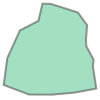

In [4]:
from shapely.geometry import Polygon

poly = Polygon(a['features'][0]['geometry']['coordinates'][0][0]) 
## Мы берем первый элемент из списка полигонов
poly

Давайте также на всякий случай проверим, что внутри нашего файла только объекты типа Multipolygon:

In [5]:
arr = []
for i in range(len(a['features'])):
    arr.append(a['features'][i]['geometry']['type'])

print(set(arr))

{'MultiPolygon'}


<b>(Задание 1)</b> У каждого полигона есть центр. Получите координаты центра полигона выше с помощью метода `.centroid`. Выведите широту и долготу численно.

In [6]:
#from shapely import Point
#p = Point(1.0, 2.0)
#print(p.x, p.y)
poly_cntr = poly.centroid
print(poly_cntr.x, poly_cntr.y)

34.87956370078355 44.854417640805515


<b>(Задание 2)</b> Для наших последующих целей нам понадобятся только те полигоны, центроиды которых лежат в центральных районах Москвы. Импортируйте файл [Полигон Москвы.geojson](https://gist.github.com/b1d7056220ab570c00a4c8347fc3bcf1) так же, как мы импортировали <i>admin_level_8.geojson</i>. В этом файле лежит единственный полигон (список features имеет длину 1). Вытащите из GeoJSON-файла координаты единственного лежащего в нем полигона, преобразуйте в `Polygon` и сохраните в переменную `moscow_poly`. Обратите внимание, что теперь вам придется работать не с форматом *Multipolygon*, а с форматом *Polygon*, поэтому вам не нужно будет опускаться в рамках списка координат на уровень ниже (нужно брать не `a['features'][0]['geometry']['coordinates'][0][0]`, а `a['features'][0]['geometry']['coordinates'][0]`).

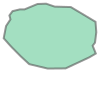

In [7]:
with open('moscow_borders/moscow_polygon.geojson', encoding = 'utf-8') as f:
    moscow_gjs = json.load(f)
moscow_poly = Polygon(moscow_gjs['features'][0]['geometry']['coordinates'][0]) 
moscow_poly

<b>(Задание 3)</b> Создайте датафрейм, колонками которого будут `id` объектов из `a`, их названия, а также широта и долгота центра мультиполигонов из файла <i>admin_level_8.geojson</i>. Назовите датафрейм `df`, а колонки с широтой и долготой — `lat` и `lon` соответственно. Это важно для последующих заданий (задание 5).

<i>Hint:</i> для создания датафрейма необходимо в цикле пройтись по массиву `features` из `a`.

In [8]:
import pandas as pd
id_gen = (a['features'][i]['id'] for i in range(len(a['features'])))
name_gen = (a['features'][i]['name'] for i in range(len(a['features'])))
centroids = [Polygon(a['features'][i]['geometry']['coordinates'][0][0]).centroid 
             for i in range(len(a['features']))]
lon_gen = (cent.x for cent in centroids)
lat_gen = (cent.y for cent in centroids)
df = pd.DataFrame([row for row in zip(id_gen, name_gen, lat_gen, lon_gen)], 
                  columns=["id", "name", "lat", "lon"])
df

,id,name,lat,lon
0,3006941,Весёловский сельский совет,44.854418,34.879564
1,3030949,Табачненский сельсовет,44.901384,33.676381
2,3030951,Угловский сельсовет,44.820806,33.603388
3,3436418,городское поселение Опочка,56.713227,28.673126
4,31001804,Бугульма,54.536056,52.797578
...,...,...,...,...
14360,5824920,Татановский сельсовет,52.870917,41.462834
14361,5824919,Горельский сельсовет,52.931384,41.530562
14362,5824921,Черняновский сельсовет,52.991688,41.519874
14363,3803358,Норово-Ротаевское сельское поселение,51.496094,38.482027


<b>(Задание 4)</b> Создайте датафрейм из файла с полигоном Москвы. В нем должна быть одна строка и два столбца: в одном название (`"Москва"`), в другом - полигон `moscow_poly`. Назовите датафрейм `df1`, а колонку с полигоном `poly` - это важно для последующих заданий (задание 5).

In [9]:
df1 = pd.DataFrame({"name": ["Москва"], "poly": [moscow_poly]})
df1

,name,poly
0,Москва,"POLYGON ((37.376684908203096 55.7957880895471,..."


<b>(Задание 5)</b> Мы хотим понять, какие из центров полигонов датафрейма `df` лежат внутри полигона Москвы. Это поможет нам выделить полигоны центральных районов Москвы. Для этого мы воспользуемся функцией библиотеки GeoPandas `sjoin`. Заметим, что `sjoin` работает только для геодатафреймов, поэтому сначала нам нужно создать два геодатафрейма из `df` и `df1`. Посмотрим, как это делается:

In [10]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df['lon'], df['lat']))
# при создании геодатафрейма нужно явно указывать, какой столбец содержит информацию
# о геоданных (geometry)
# в случае с gdf мы сказали, что этот столбец нужно создать, используя
# координаты точек, хранящиеся в столбцах `lon` и `lat`

gdf1 = gpd.GeoDataFrame(df1, geometry = 'poly')
# в этом случае мы сказали, что нужно просто взять содержимое столбца `poly`
# в качестве `geometry`

In [11]:
gdf.head(2)

,id,name,lat,lon,geometry
0,3006941,Весёловский сельский совет,44.854418,34.879564,POINT (34.87956 44.85442)
1,3030949,Табачненский сельсовет,44.901384,33.676381,POINT (33.67638 44.90138)


In [12]:
gdf1.head(2)

,name,poly
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152..."


In [13]:
type(gdf1)

geopandas.geodataframe.GeoDataFrame

In [14]:
gdf1

,name,poly
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152..."


In [15]:
type(df1)

pandas.core.frame.DataFrame

Примените функцию `sjoin` с параметром `op="intersects"` к геодатафреймам выше и создайте геодатафрейм только с теми полигонами, центроиды которых лежат в полигоне Москвы. Прочитайте подробнее о spatial join в [документации](https://geopandas.org/docs/user_guide/mergingdata.html). Обратите внимание на параметр `how` и вспомните <mark>пары по SQL</mark>. Что вам нужно выбрать: `right/left/inner`?

<i>Hint:</i> специфицировать никакие параметры, кроме `op` и `how`, не нужно.

In [16]:
# left: use the index from the first (or left_df) GeoDataFrame that you provide to GeoDataFrame.sjoin(); 
# retain only the left_df geometry column
moscow_polyes = gdf1.sjoin(gdf, how="left", predicate='intersects')
moscow_polyes

,name_left,poly,index_right,id,name_right,lat,lon
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",3735,950658,район Бирюлёво Западное,55.586917,37.637628
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",9195,950664,район Чертаново Южное,55.591723,37.600302
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",12644,950639,район Бирюлёво Восточное,55.594604,37.678865
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",6770,456807,район Орехово-Борисово Южное,55.604342,37.733035
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",9194,951334,район Ясенево,55.612846,37.546731
...,...,...,...,...,...,...,...
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",6766,1252448,Лосиноостровский район,55.881164,37.694035
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",7937,446086,район Северное Медведково,55.888217,37.654994
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",4029,445278,Дмитровский район,55.891370,37.528422
0,Москва,"POLYGON ((37.37668 55.79579, 37.36433 55.73152...",7938,446085,район Бибирево,55.894986,37.607985


<b>(Задание 6)</b> Выше вы видели пример создания геодатафрейма (задание 5). Создайте датафрейм с колонками `id` (id полигона), `name` (название полигона) и `poly` (геометрическая сущность Polygon, полученная с помощью библиотеки shapely). Преобразуйте данные в геодатафрейм. Возьмите данные из файла <i>admin_level_8.geojson</i>. В геодатафрейме должны быть только полигоны, центроиды которых лежат в полигоне Москвы, их `id` вы должны были получить в предыдущем задании. Обратите внимание, что теперь геометрией должен выступать полигон (параметр `geometry` в GeoDataFrame).

In [17]:
950658 in moscow_polyes.id.values

True

In [18]:
# | id | name | poly |
id_gen = (a['features'][i]['id'] for i in range(len(a['features'])))
name_gen = (a['features'][i]['name'] for i in range(len(a['features'])))
polygon_gen = (Polygon(a['features'][i]['geometry']['coordinates'][0][0]) for i in range(len(a['features'])))
mos_polyes_df = pd.DataFrame([row for row in zip(id_gen, name_gen, polygon_gen) if row[0] in moscow_polyes.id.values], 
                               columns=["id", "name", "poly"])
#mos_polyes_df =  pd.DataFrame([(a['features'][i]['id'], a['features'][i]['name'], Polygon(a['features'][i]['geometry']['coordinates'][0][0])) 
#                                for i in range(len(a['features']) if a['features'][i]['id'] moscow_polyes.id.values],
#                                columns=["id", "name", "poly"])

mos_polyes_df 

,id,name,poly
0,446083,Алтуфьевский район,"POLYGON ((37.6071633 55.8793205, 37.6067652000..."
1,446114,район Дорогомилово,"POLYGON ((37.5744493 55.746327300000004, 37.57..."
2,446080,район Южное Тушино,"POLYGON ((37.469885399999995 55.8431779, 37.46..."
3,446084,район Лианозово,"POLYGON ((37.59073530000001 55.9136561, 37.590..."
4,574667,район Вешняки,"POLYGON ((37.842683799999996 55.749073, 37.828..."
...,...,...,...
101,1299013,район Перово,"POLYGON ((37.808700900000005 55.7602404, 37.80..."
102,1319263,район Ивановское,POLYGON ((37.850473099999995 55.77890360000001...
103,364001,Мещанский район,"POLYGON ((37.6448792 55.779765000000005, 37.64..."
104,1257786,Тверской район,"POLYGON ((37.634963 55.7537872, 37.63444959999..."


In [19]:
mos_polyes_df.loc[mos_polyes_df.id == 446083, "poly"]

0    POLYGON ((37.6071633 55.8793205, 37.6067652000...
Name: poly, dtype: object

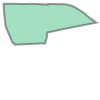

In [20]:
mos_polyes_df.loc[0, "poly"]

In [21]:
mos_polyes_gdf = gpd.GeoDataFrame(mos_polyes_df, geometry = 'poly')
mos_polyes_gdf

,id,name,poly
0,446083,Алтуфьевский район,"POLYGON ((37.60716 55.87932, 37.60677 55.87968..."
1,446114,район Дорогомилово,"POLYGON ((37.57445 55.74633, 37.57413 55.74545..."
2,446080,район Южное Тушино,"POLYGON ((37.46989 55.84318, 37.46885 55.84354..."
3,446084,район Лианозово,"POLYGON ((37.59074 55.91366, 37.59025 55.91296..."
4,574667,район Вешняки,"POLYGON ((37.84268 55.74907, 37.82808 55.74616..."
...,...,...,...
101,1299013,район Перово,"POLYGON ((37.80870 55.76024, 37.80655 55.76056..."
102,1319263,район Ивановское,"POLYGON ((37.85047 55.77890, 37.85000 55.77893..."
103,364001,Мещанский район,"POLYGON ((37.64488 55.77977, 37.64397 55.77969..."
104,1257786,Тверской район,"POLYGON ((37.63496 55.75379, 37.63445 55.75365..."


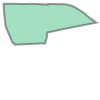

In [22]:
mos_polyes_gdf.loc[0, "poly"]

In [23]:
import pandas as pd
import geopandas as gpd
import folium
import geodatasets
import matplotlib.pyplot as plt

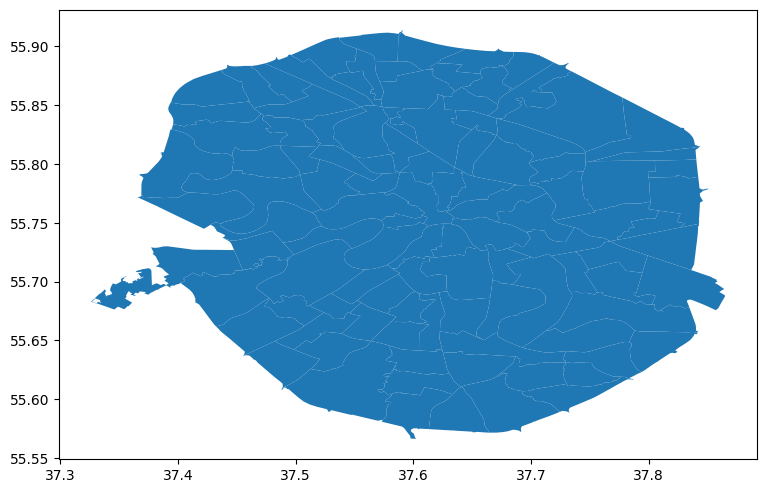

In [24]:
mos_polyes_gdf.plot(figsize=(9, 9))
plt.show()

In [25]:
m = folium.Map(location=[55.75, 37.70], zoom_start=10, tiles="CartoDB positron")
m

In [26]:
it = mos_polyes_gdf.iterrows()
next(it)

(0,
 id                                                 446083
 name                                   Алтуфьевский район
 poly    POLYGON ((37.6071633 55.8793205, 37.6067652000...
 Name: 0, dtype: object)

In [27]:
for _, r in mos_polyes_gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["poly"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["name"]).add_to(geo_j)
    geo_j.add_to(m)
m

<b>(Задание 7)</b> Создайте геодатафрейм, где геометрией выступают координаты точек Банкоматов Тинькофф. Примените функцию `sjoin` к данному датафрейму и датафрейму, полученному в задании 6. Удалите из рассмотрения все точки банкоматов, координаты которых лежат не в центральных районах Москвы.

In [28]:
ATMs_df = pd.read_excel("ATMS/atms_moscow.xlsx")
ATMs_df

,id,city,latitude,longitude
0,1,Москва,55.804936,37.589948
1,2,Москва,55.715191,37.519281
2,3,Москва,55.776535,37.533362
3,4,Москва,55.742845,37.418416
4,5,Москва,55.605490,37.716139
...,...,...,...,...
883,884,Москва,55.792733,37.787147
884,885,Москва,55.621422,37.737907
885,886,Москва,55.624933,37.421861
886,887,Москва,55.771176,37.586441


In [29]:
ATMs_gdf = gpd.GeoDataFrame(ATMs_df, geometry = gpd.points_from_xy(ATMs_df['longitude'], ATMs_df['latitude']))
ATMs_gdf

,id,city,latitude,longitude,geometry
0,1,Москва,55.804936,37.589948,POINT (37.58995 55.80494)
1,2,Москва,55.715191,37.519281,POINT (37.51928 55.71519)
2,3,Москва,55.776535,37.533362,POINT (37.53336 55.77654)
3,4,Москва,55.742845,37.418416,POINT (37.41842 55.74285)
4,5,Москва,55.605490,37.716139,POINT (37.71614 55.60549)
...,...,...,...,...,...
883,884,Москва,55.792733,37.787147,POINT (37.78715 55.79273)
884,885,Москва,55.621422,37.737907,POINT (37.73791 55.62142)
885,886,Москва,55.624933,37.421861,POINT (37.42186 55.62493)
886,887,Москва,55.771176,37.586441,POINT (37.58644 55.77118)


In [30]:
ATMs_moscow_gdf = ATMs_gdf.sjoin(mos_polyes_gdf, how="inner", predicate='intersects')
ATMs_moscow_gdf

,id_left,city,latitude,longitude,geometry,index_right,id_right,name
0,1,Москва,55.804936,37.589948,POINT (37.58995 55.80494),87,1252424,Бутырский район
169,170,Москва,55.800412,37.594211,POINT (37.59421 55.80041),87,1252424,Бутырский район
344,345,Москва,55.813657,37.604297,POINT (37.60430 55.81366),87,1252424,Бутырский район
383,384,Москва,55.822628,37.590024,POINT (37.59002 55.82263),87,1252424,Бутырский район
452,453,Москва,55.819303,37.578115,POINT (37.57811 55.81930),87,1252424,Бутырский район
...,...,...,...,...,...,...,...,...
713,714,Москва,55.802211,37.531908,POINT (37.53191 55.80221),84,446079,район Аэропорт
719,720,Москва,55.788430,37.567242,POINT (37.56724 55.78843),84,446079,район Аэропорт
786,787,Москва,55.788556,37.567364,POINT (37.56736 55.78856),84,446079,район Аэропорт
799,800,Москва,55.801576,37.531257,POINT (37.53126 55.80158),84,446079,район Аэропорт


<b>(Задание 8)</b> Посмотрите, в каких из центральных районов больше банкоматов. Создайте геодатафрейм, в котором геометрией являются полигоны, и раскрасьте районы в зависимости от количества пунктов выдачи.

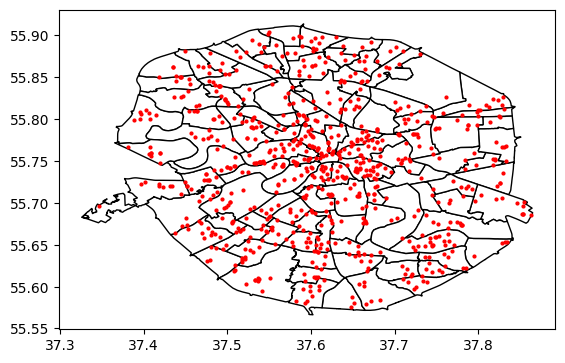

In [31]:
base = mos_polyes_gdf.plot(color='white', edgecolor='black')
ATMs_moscow_gdf.plot(ax=base, marker='o', color='red', markersize=4, figsize=(9, 16));

In [32]:
len(ATMs_moscow_gdf[ATMs_moscow_gdf.name == "Бутырский район"])

9

In [33]:
id_gen = (a['features'][i]['id'] for i in range(len(a['features'])))
name_gen = (a['features'][i]['name'] for i in range(len(a['features'])))
ATMs_num_gen = (len(ATMs_moscow_gdf[ATMs_moscow_gdf.name == a['features'][i]['name']])  for i in range(len(a['features'])))
polygon_gen = (Polygon(a['features'][i]['geometry']['coordinates'][0][0]) for i in range(len(a['features'])))
mos_ATMs_stats_df = pd.DataFrame([row for row in zip(id_gen, name_gen, ATMs_num_gen, polygon_gen) if row[0] in moscow_polyes.id.values], 
                               columns=["id", "name", "ATMs_num", "poly"])
mos_ATMs_stats_df

,id,name,ATMs_num,poly
0,446083,Алтуфьевский район,3,"POLYGON ((37.6071633 55.8793205, 37.6067652000..."
1,446114,район Дорогомилово,8,"POLYGON ((37.5744493 55.746327300000004, 37.57..."
2,446080,район Южное Тушино,6,"POLYGON ((37.469885399999995 55.8431779, 37.46..."
3,446084,район Лианозово,4,"POLYGON ((37.59073530000001 55.9136561, 37.590..."
4,574667,район Вешняки,4,"POLYGON ((37.842683799999996 55.749073, 37.828..."
...,...,...,...,...
101,1299013,район Перово,3,"POLYGON ((37.808700900000005 55.7602404, 37.80..."
102,1319263,район Ивановское,5,POLYGON ((37.850473099999995 55.77890360000001...
103,364001,Мещанский район,7,"POLYGON ((37.6448792 55.779765000000005, 37.64..."
104,1257786,Тверской район,26,"POLYGON ((37.634963 55.7537872, 37.63444959999..."


In [34]:
mos_ATMs_stats_gdf = gpd.GeoDataFrame(mos_ATMs_stats_df, geometry="poly") 

/home/artee/.local/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 15 classes. Setting k to 13.
  self.bins = quantile(y, k=k)


<Axes: >

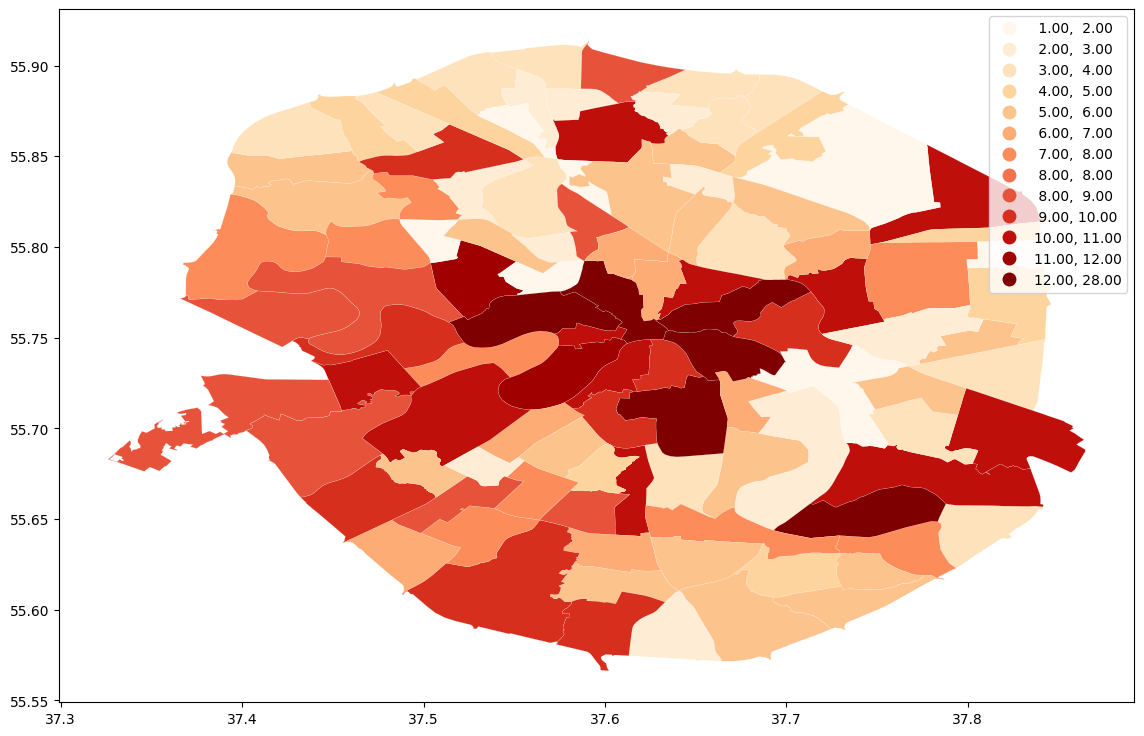

In [35]:
mos_ATMs_stats_gdf.plot(column='ATMs_num', 
                        cmap='OrRd',  
                        scheme='quantiles', 
                        legend=True,
                       figsize=(16, 9),
    categorical=True,
    k=15,
    linewidth=0.1,
    edgecolor="white",
)

    

На графике более чувствительная раскраска, ее можно сделать менее грубой

<Axes: >

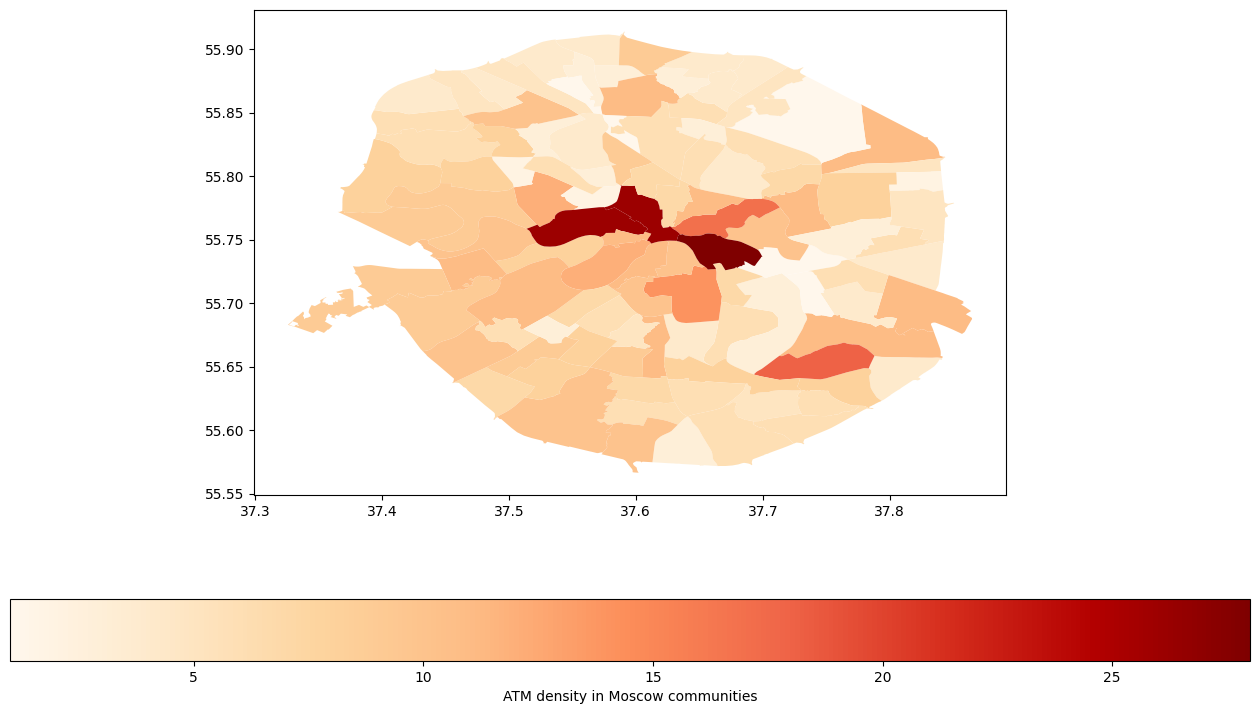

In [36]:
mos_ATMs_stats_gdf.plot(column='ATMs_num', 
                        cmap='OrRd',  
                        legend=True,
                       legend_kwds={"label": "ATM density in Moscow communities", "orientation": "horizontal"},
                       figsize=(16, 9),
                       )


{'id': '0', 'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': [[[37.6071633, 55.8793205], [37.5948136, 55.8869043], [37.5674047, 55.8873023], [37.56829090000001, 55.8775903], [37.572183800000005, 55.86953330000001], [37.585298800000004, 55.8700079], [37.5862778, 55.87481399999999], [37.6071633, 55.8793205]]]}, 'bbox': [37.5674047, 55.86953330000001, 37.6071633, 55.8873023]}

In [37]:
from branca.colormap import linear

colormap = linear.YlGn_09.scale(
    mos_ATMs_stats_gdf.ATMs_num.values.min(), mos_ATMs_stats_gdf.ATMs_num.values.max()
)

print(colormap(20.0))

colormap



#2e934cff


In [38]:
mos_ATMs_stats_gdf

,id,name,ATMs_num,poly
0,446083,Алтуфьевский район,3,"POLYGON ((37.60716 55.87932, 37.60677 55.87968..."
1,446114,район Дорогомилово,8,"POLYGON ((37.57445 55.74633, 37.57413 55.74545..."
2,446080,район Южное Тушино,6,"POLYGON ((37.46989 55.84318, 37.46885 55.84354..."
3,446084,район Лианозово,4,"POLYGON ((37.59074 55.91366, 37.59025 55.91296..."
4,574667,район Вешняки,4,"POLYGON ((37.84268 55.74907, 37.82808 55.74616..."
...,...,...,...,...
101,1299013,район Перово,3,"POLYGON ((37.80870 55.76024, 37.80655 55.76056..."
102,1319263,район Ивановское,5,"POLYGON ((37.85047 55.77890, 37.85000 55.77893..."
103,364001,Мещанский район,7,"POLYGON ((37.64488 55.77977, 37.64397 55.77969..."
104,1257786,Тверской район,26,"POLYGON ((37.63496 55.75379, 37.63445 55.75365..."


In [39]:
arr = [key for key, r in mos_ATMs_stats_gdf.iterrows()]
arr

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105]

In [40]:
color_dict = {key: colormap(mos_ATMs_stats_gdf.ATMs_num.values[key]) for key, r in mos_ATMs_stats_gdf.iterrows()}
color_dict
#color_dict = {key: colormap(unemployment_dict[key]) for key in unemployment_dict.keys()}
#atms_dict = mos_ATMs_stats_gdf.set_index("id")["ATMs_num"]

#atms_dict['0']

{0: '#fbfecbff',
 1: '#d6efa2ff',
 2: '#e9f7afff',
 3: '#f8fdbeff',
 4: '#f8fdbeff',
 5: '#e9f7afff',
 6: '#afde8fff',
 7: '#f2fab5ff',
 8: '#f8fdbeff',
 9: '#fbfecbff',
 10: '#afde8fff',
 11: '#c9e99bff',
 12: '#f8fdbeff',
 13: '#f8fdbeff',
 14: '#afde8fff',
 15: '#afde8fff',
 16: '#d6efa2ff',
 17: '#9fd789ff',
 18: '#fbfecbff',
 19: '#f2fab5ff',
 20: '#9fd789ff',
 21: '#fbfecbff',
 22: '#f8fdbeff',
 23: '#fdffd8ff',
 24: '#afde8fff',
 25: '#f8fdbeff',
 26: '#fbfecbff',
 27: '#e9f7afff',
 28: '#f2fab5ff',
 29: '#fbfecbff',
 30: '#e9f7afff',
 31: '#d6efa2ff',
 32: '#e0f3a8ff',
 33: '#e0f3a8ff',
 34: '#afde8fff',
 35: '#e9f7afff',
 36: '#f8fdbeff',
 37: '#f8fdbeff',
 38: '#d6efa2ff',
 39: '#e9f7afff',
 40: '#e9f7afff',
 41: '#fbfecbff',
 42: '#f8fdbeff',
 43: '#e9f7afff',
 44: '#afde8fff',
 45: '#40aa5cff',
 46: '#d6efa2ff',
 47: '#e9f7afff',
 48: '#c9e99bff',
 49: '#fdffd8ff',
 50: '#80ca7cff',
 51: '#ffffe5ff',
 52: '#f2fab5ff',
 53: '#ffffe5ff',
 54: '#afde8fff',
 55: '#fbfecbff',
 5

In [41]:
it = mos_ATMs_stats_gdf.iterrows()
a, b = next(it)
print(a)
print(colormap(mos_ATMs_stats_gdf.loc[a, "ATMs_num"]))
#print(b)
#print(type(mos_ATMs_stats_gdf.loc[a, "ATMs_num"]))
#print(type(mos_ATMs_stats_gdf.ATMs_num.values[a]))
a, b = next(it)
#print(a)
#print(colormap(mos_ATMs_stats_gdf.loc[a, "ATMs_num"]))
b

0
#fbfecbff


id                                                     446114
name                                       район Дорогомилово
ATMs_num                                                    8
poly        POLYGON ((37.5744493 55.746327300000004, 37.57...
Name: 1, dtype: object

In [42]:
for a, r in mos_ATMs_stats_gdf.iterrows():
    print(type(colormap(mos_ATMs_stats_gdf.ATMs_num.values[a])))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [43]:
m1 = folium.Map(location=[55.75, 37.70], zoom_start=10, tiles="CartoDB positron")

for a, r in mos_ATMs_stats_gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r["poly"]).simplify(tolerance=0.001)
    geo_j = gpd.GeoSeries(r["poly"]).to_json()
    geo_j = geo_j.replace('"id": "0"', '"id": "' + str(a) + '"')
    geo_j = folium.GeoJson(geo_j, 
                           style_function=lambda feature: {
                                                            "fillColor": color_dict[int(feature["id"])],
                                                            "color": "black",
                                                            "weight": 1,
                                                            "dashArray": "5, 5",
                                                            "fillOpacity": 0.9,
    },)
    folium.Popup(r["name"] + "\nATMs:" + str(r["ATMs_num"])).add_to(geo_j)
    geo_j.add_to(m1)

folium.LayerControl().add_to(m1)
m1

# geo_j = mos_ATMs_stats_gdf.to_json()

# for a, r in mos_ATMs_stats_gdf.iterrows():
#     folium.Popup(r["name"]).add_to(geo_j)

# folium.GeoJson(
#     geo_j,
#     name="ATMS",
#     style_function=lambda feature: {
#         "fillColor": color_dict[int(feature["id"])],
#         "color": "black",
#         "weight": 1,
#         "dashArray": "5, 5",
#         "fillOpacity": 0.9,
#     },
# ).add_to(m1)
# m1

# m = folium.Map([43, -100], zoom_start=4)

# folium.GeoJson(
#     geo_json_data,
#     name="unemployment",
#     style_function=lambda feature: {
#         "fillColor": colormap(unemployment_dict[feature["id"]]),
#         "color": "black",
#         "weight": 1,
#         "dashArray": "5, 5",
#         "fillOpacity": 0.9,
#     },
# ).add_to(m)

# folium.LayerControl().add_to(m)

# m

Здесь нужно подебагать чтобы заработал colormap и можно было сделать сверху как на output 35.
Дальше разрисовать москву в гексагоны (возможно с административными округами) и там данные Софа должна скинуть по транзакциям данные разбить на гексагоны и кластеризовать на 6 классов там еще комментарии в избранном в тг есть